In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/Portuguese.txt', 'data/names/Dutch.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt', 'data/names/French.txt', 'data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/Vietnamese.txt', 'data/names/Italian.txt', 'data/names/Russian.txt', 'data/names/Chinese.txt', 'data/names/English.txt']


In [6]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

#creates a list of categories (which correspond to languages) and creates a dictionary with each of those categories as a key
#and a list of the names as its value
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(all_letters)

Slusarski
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


Now we have category_lines, a dictionary mapping each category (language) to a list of lines (names). We also kept track of all_categories (just a list of languages) and n_categories for later reference.

In [5]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) #creates a tensor (in this case a vector), corr to one-hot
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


![arch image](arch_image.png)

In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size # the hidden size is a size you choose as a parameter

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #normal NN layers, input + hidden, hidden
        self.i2o = nn.Linear(input_size + hidden_size, output_size) #normal NN layers, input + hidden, output
        self.softmax = nn.LogSoftmax(dim=1) #softmax to get the correct probabilities

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) #concatenate the hidden and the input tensors
        hidden = self.i2h(combined) #hidden is created with i2h layer from combined
        output = self.i2o(combined) #output is created from i2o layer from combined
        output = self.softmax(output) #output is fed through the softmax activation layer
        return output, hidden #the output contains both the output for that layer and the hidden layer

    def initHidden(self):
        return torch.zeros(1, self.hidden_size) #initializes the hidden layer to zeros

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [10]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [11]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8965, -2.8877, -2.8047, -2.9618, -2.8665, -2.9005, -2.9927, -2.8981,
         -2.8701, -2.9559, -2.8769, -2.8228, -2.9624, -2.9467, -2.8342, -2.8851,
         -2.8607, -2.8279]], grad_fn=<LogSoftmaxBackward>)


In [12]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) #returns the highest ranking class
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 2)


In [13]:
#This cell chooses random training examples 

import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Song
category = Italian / line = Sorrentino
category = Portuguese / line = Abreu
category = English / line = Mckee
category = Greek / line = Kolovos
category = Vietnamese / line = Chu
category = French / line = Babineaux
category = Scottish / line = Robertson
category = Chinese / line = Law
category = Portuguese / line = Basurto


In [14]:
criterion = nn.NLLLoss() #remember how I said cross entropy is also called negative log likelihood loss?

In [15]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad() #this clears old gradients from the last time step

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden) #provides the input and hidden to the rnn, starts with zeros for hidden and learns hidden as it goes

    loss = criterion(output, category_tensor) #calculates the cross entropy loss
    loss.backward() # computes the derivative of the loss w.r.t. the parameters using backpropagation

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data) #subtracts the learning rate

    return output, loss.item() #returns the output and the loss

In [16]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.4659 Vo / Korean ✗ (Vietnamese)
10000 10% (0m 12s) 3.0722 Masson / Scottish ✗ (French)
15000 15% (0m 19s) 2.3700 Eyre / English ✓
20000 20% (0m 25s) 0.7046 Jon / Korean ✓
25000 25% (0m 31s) 2.5615 Jamieson / Scottish ✗ (English)
30000 30% (0m 38s) 1.7840 Cardozo / Italian ✗ (Portuguese)
35000 35% (0m 44s) 2.1066 Rubio / Portuguese ✗ (Spanish)
40000 40% (0m 50s) 2.4663 Mata / Japanese ✗ (Portuguese)
45000 45% (0m 57s) 2.5617 Reardon / Irish ✗ (English)
50000 50% (1m 4s) 0.2566 Yeon / Korean ✓
55000 55% (1m 12s) 0.8798 Long / Chinese ✓
60000 60% (1m 19s) 0.2780 Hamada / Japanese ✓
65000 65% (1m 25s) 1.2797 Viola / Spanish ✓
70000 70% (1m 32s) 0.7241 Antonopoulos / Greek ✓
75000 75% (1m 41s) 0.6087 Wojewodka / Polish ✓
80000 80% (1m 50s) 0.0895 Petimezas / Greek ✓
85000 85% (1m 59s) 2.2219 Villaverde / Italian ✗ (Spanish)
90000 90% (2m 7s) 0.2927 Mclean / Scottish ✓
95000 95% (2m 14s) 0.8686 Amari / Arabic ✓
100000 100% (2m 22s) 1.8168 Koo / Korean ✗ (Chinese)


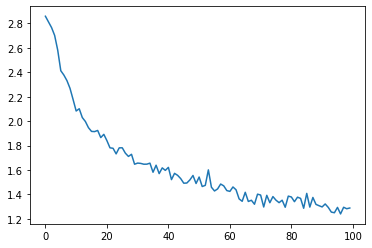

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

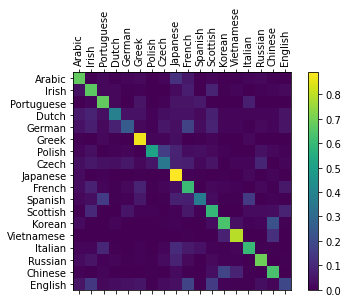

In [18]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [19]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [31]:
predict('Misenheimer')


> Misenheimer
(-0.41) Dutch
(-2.40) German
(-2.56) Czech
